In [1]:
from collections import Counter, defaultdict, deque
import matplotlib.pyplot as plt
import networkx as nx
import sys
import time
from TwitterAPI import TwitterAPI, TwitterOAuth, TwitterRestPager
import numpy as np
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
%matplotlib inline
import copy
import math
import urllib.request

In [2]:
def get_twitter():
    """ Construct an instance of TwitterAPI using the tokens you entered above.
    Returns:
      An instance of TwitterAPI.
    """
    o = TwitterOAuth.read_file('credentials.txt')
    # Using OAuth1...
    twitter = TwitterAPI(o.consumer_key,
                 o.consumer_secret,
                 o.access_token_key,
                 o.access_token_secret)
    return twitter

In [3]:
def robust_request(twitter, resource, params, max_tries=5):
    """ If a Twitter request fails, sleep for 15 minutes.
    Do this at most max_tries times before quitting.
    Args:
      twitter .... A TwitterAPI object.
      resource ... A resource string to request; e.g., "friends/ids"
      params ..... A parameter dict for the request, e.g., to specify
                   parameters like screen_name or count.
      max_tries .. The maximum number of tries to attempt.
    Returns:
      A TwitterResponse object, or None if failed.
    """
    for i in range(max_tries):
        request = twitter.request(resource, params)
        if request.status_code == 200:
            return request
        else:
            print('Got error %s \nsleeping for 15 minutes.' % request.text)
            sys.stderr.flush()
            time.sleep(61 * 15)

In [4]:
def read_screen_names(filename):
    """
    Read a text file containing Twitter screen_names, one per line.
    Params:
        filename....Name of the file to read.
    Returns:
        A list of strings, one per screen_name, in the order they are listed
        in the file.
    Here's a doctest to confirm your implementation is correct.
    >>> read_screen_names('candidates.txt')
    ['DrJillStein', 'GovGaryJohnson', 'HillaryClinton', 'realDonaldTrump']
    """
    ###TODO
    file = open(filename)
    name_list = file.read()
    screen_names = name_list.split('\n')
    return list(filter(None, screen_names))
    pass

In [5]:
def get_users(twitter, screen_names):
    """Retrieve the Twitter user objects for each screen_name.
    Params:
        twitter........The TwitterAPI object.
        screen_names...A list of strings, one per screen_name
    Returns:
        A list of dicts, one per user, containing all the user information
        (e.g., screen_name, id, location, etc)
    See the API documentation here: https://dev.twitter.com/rest/reference/get/users/lookup
    In this example, I test retrieving two users: twitterapi and twitter.
    >>> twitter = get_twitter()
    >>> users = get_users(twitter, ['twitterapi', 'twitter'])
    >>> [u['id'] for u in users]
    [6253282, 783214]
    """
    ###TODO
    request = robust_request(twitter,'users/lookup',{'screen_name': screen_names})
    return request
    pass


def get_friends(twitter, screen_name):
    """ Return a list of Twitter IDs for users that this person follows, up to 5000.
    See https://dev.twitter.com/rest/reference/get/friends/ids
    Note, because of rate limits, it's best to test this method for one candidate before trying
    on all candidates.
    Args:
        twitter.......The TwitterAPI object
        screen_name... a string of a Twitter screen name
    Returns:
        A list of ints, one per friend ID, sorted in ascending order.
    Note: If a user follows more than 5000 accounts, we will limit ourselves to
    the first 5000 accounts returned.
    In this test case, I return the first 5 accounts that I follow.
    >>> twitter = get_twitter()
    >>> get_friends(twitter, 'aronwc')[:5]
    [695023, 1697081, 8381682, 10204352, 11669522]
    """
    ###TODO
    request = robust_request(twitter, 'friends/ids', {'screen_name':screen_name,'count': 5000})
    fid = []
    for r in request:
        fid.extend([r])
    return sorted(fid)
    pass



def add_all_friends(twitter, users):
    """ Get the list of accounts each user follows.
    I.e., call the get_friends method for all 4 candidates.
    Store the result in each user's dict using a new key called 'friends'.
    Args:
        twitter...The TwitterAPI object.
        users.....The list of user dicts.
    Returns:
        Nothing
    >>> twitter = get_twitter()
    >>> users = [{'screen_name': 'aronwc'}]
    >>> add_all_friends(twitter, users)
    >>> users[0]['friends'][:5]
    [695023, 1697081, 8381682, 10204352, 11669522]
    """
    ###TODO
    for u in users:
        u['friends'] = get_friends(twitter, u['screen_name'])
    pass


def print_num_friends(users):
    """Print the number of friends per candidate, sorted by candidate name.
    See Log.txt for an example.
    Args:
        users....The list of user dicts.
    Returns:
        Nothing
    """
    ###TODO
    sorted(users, key=lambda x: x['screen_name'])
    for u in users:
        print('%s %d'%(u['screen_name'],len(u['friends'])))
    pass


def count_friends(users):
    """ Count how often each friend is followed.
    Args:
        users: a list of user dicts
    Returns:
        a Counter object mapping each friend to the number of candidates who follow them.
        Counter documentation: https://docs.python.org/dev/library/collections.html#collections.Counter
    In this example, friend '2' is followed by three different users.
    >>> c = count_friends([{'friends': [1,2]}, {'friends': [2,3]}, {'friends': [2,3]}])
    >>> c.most_common()
    [(2, 3), (3, 2), (1, 1)]
    """
    ###TODO
    c = Counter()
    for u in users:
       c.update(u['friends'])
    return c
    pass


def friend_overlap(users):
    """
    Compute the number of shared accounts followed by each pair of users.
    Args:
        users...The list of user dicts.
    Return: A list of tuples containing (user1, user2, N), where N is the
        number of accounts that both user1 and user2 follow.  This list should
        be sorted in descending order of N. Ties are broken first by user1's
        screen_name, then by user2's screen_name (sorted in ascending
        alphabetical order). See Python's builtin sorted method.
    In this example, users 'a' and 'c' follow the same 3 accounts:
    >>> friend_overlap([
    ...     {'screen_name': 'a', 'friends': ['1', '2', '3']},
    ...     {'screen_name': 'b', 'friends': ['2', '3', '4']},
    ...     {'screen_name': 'c', 'friends': ['1', '2', '3']},
    ...     ])
    [('a', 'c', 3), ('a', 'b', 2), ('b', 'c', 2)]
    """
    ###TODO
    list = []
    user_list = len(users)
    for i in range(user_list):
        for j in range(i+1, user_list):
            # temp_list = []
            temp_list = users[i]['friends']+(users[j]['friends'])
            common = Counter(temp_list).most_common()
            num = sum([int(i[1])>1 for i in common])
            list.append((users[i]['screen_name'], users[j]['screen_name'],num))
    return sorted(list,key=lambda x: -x[2])

def create_graph(users, friend_counts):
    """ Create a networkx undirected Graph, adding each candidate and friend
        as a node.  Note: while all candidates should be added to the graph,
        only add friends to the graph if they are followed by more than one
        candidate. (This is to reduce clutter.)
        Each candidate in the Graph will be represented by their screen_name,
        while each friend will be represented by their user id.
    Args:
      users...........The list of user dicts.
      friend_counts...The Counter dict mapping each friend to the number of candidates that follow them.
    Returns:
      A networkx Graph
    """
    ###TODO
    graph = nx.Graph()
    for u in users:
        u_name = u['screen_name']
        u_friends = u['friends']
        graph.add_node(u_name)
        for f_id in u_friends:
            if friend_counts[f_id]>1:
                graph.add_edge(u_name,f_id)
    return graph
    pass

def draw_network(graph, users, filename):
    """
    Draw the network to a file. Only label the candidate nodes; the friend
    nodes should have no labels (to reduce clutter).
    Methods you'll need include networkx.draw_networkx, plt.figure, and plt.savefig.
    Your figure does not have to look exactly the same as mine, but try to
    make it look presentable.
    """
    ###TODO
    screen_name =[u['screen_name'] for u in users]
    labels = {n:n if n in screen_name else '' for n in graph.nodes()}
    plt.figure(figsize=(16,16))
    nx.draw_networkx(graph, labels=labels, node_size=100,alfa =0.5, width = 0.1)
    plt.axis("off")
    plt.savefig(filename)
    plt.show()
    pass



In [12]:
def get_subgraph(graph, min_degree):

    # subgraph = nx.Graph()
    nodes = [n for n in graph.nodes() if graph.degree(n) >= min_degree]
    #     for n in graph.nodes():
    #         # if len(graph.neighbors(n))>=min_degree:
    #         if graph.degree(n) >= min_degree:
    #             nodes.append(n)
    subgraph = graph.subgraph(nodes)
    return subgraph

def girvan_newman(graph, minsize=30, maxsize=200):

    if graph.order() == 1:
        return [graph.nodes()]
    G = graph.copy()
    btn = nx.edge_betweenness_centrality(G)
    sbtn = sorted(btn.items(), key=lambda x: x[1], reverse=True)

    components = [c for c in nx.connected_component_subgraphs(G)]
    
    i = 0
    while len(components) == 1:
        G.remove_edge(*sbtn[0][0])
        i+=1
        del sbtn[0]
        components = [c for c in nx.connected_component_subgraphs(G)]

    gs = []
    for c in components:
        if len(c) >= minsize and len(c) <= maxsize:
            gs.append(c)
            print ('stoping for size of a component %s' % len(c))
        elif len(c) > maxsize:
            gs.extend(girvan_newman(c))

    return gs



In [19]:
def get_cluster_size(result):
    clus = [len(x) for x in result]
    with open('clusters.txt', 'w') as fp:
        for x in result:
            print(len(x), file= fp)
    return clus


In [10]:
def draw_subgraphs(graph,users, result):
    i=0
    for cluster in result:
        fn = '%d_subnetwork.png'%i
        draw_network(graph.subgraph(cluster),users,fn)
        i+=1

Read screen names: ['exploretravel1', 'Interior', 'GWPStudio', 'John_M_Bailey', 'edaccessible', 'realtyand', 'Britanniacomms', 'TWEETSARCASIM', 'BonVoyageurs', 'historylvrsclub', 'BestWorldPix', 'TravelPoorn', 'blicqer', 'EseJapan']
found 14 users with screen_names ['BestWorldPix', 'BonVoyageurs', 'Britanniacomms', 'EseJapan', 'GWPStudio', 'Interior', 'John_M_Bailey', 'TWEETSARCASIM', 'TravelPoorn', 'blicqer', 'edaccessible', 'exploretravel1', 'historylvrsclub', 'realtyand']
Friends per candidate:
BestWorldPix 5000
BonVoyageurs 5000
Britanniacomms 5000
EseJapan 5000
GWPStudio 5000
Interior 5000
John_M_Bailey 5000
TWEETSARCASIM 5000
TravelPoorn 5000
blicqer 5000
edaccessible 5000
exploretravel1 5000
historylvrsclub 5000
realtyand 5000
Most common friends:
[(151805556, 4), (4739291374, 4), (4562660358, 3), (750642095191420928, 3), (3012434073, 3)]
Friend Overlap:
[('John_M_Bailey', 'edaccessible', 122), ('edaccessible', 'realtyand', 85), ('John_M_Bailey', 'realtyand', 57), ('EseJapan', '

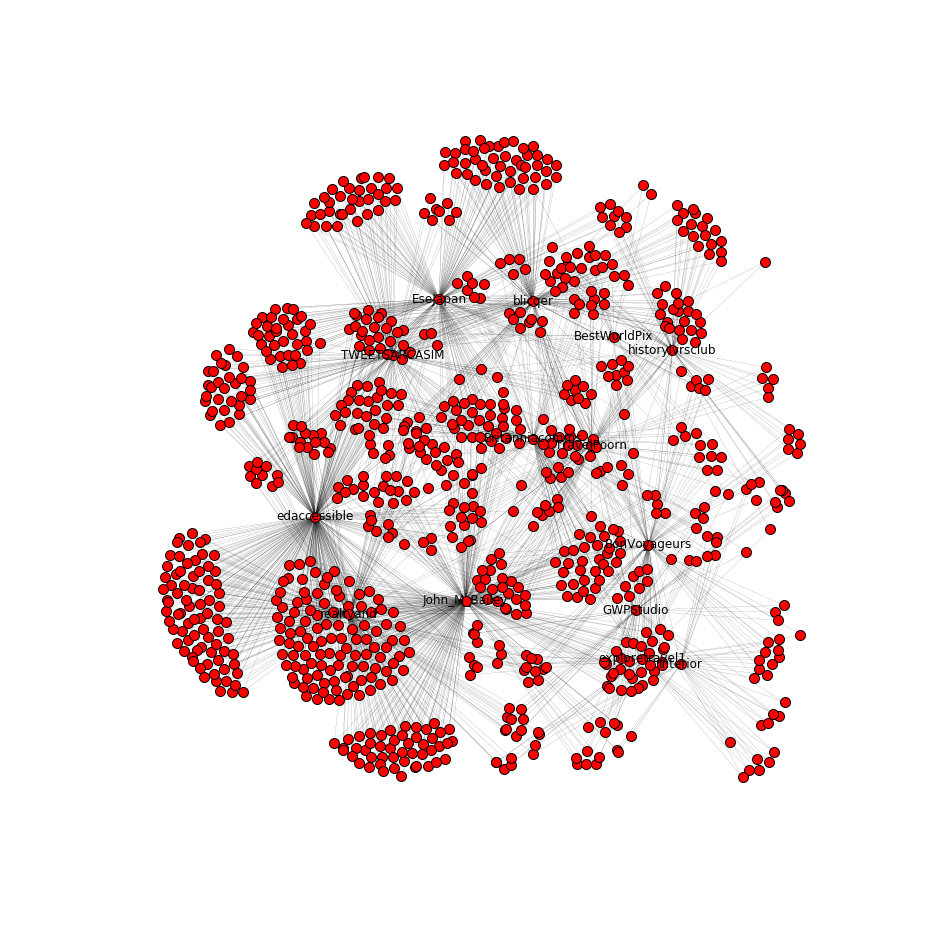

network drawn to network.png
graph has 992 nodes and 2003 edges
subgraph has 992 nodes and 2003 edges
stoping for size of a component 100
stoping for size of a component 100
stoping for size of a component 70
stoping for size of a component 65
stoping for size of a component 38
stoping for size of a component 30
stoping for size of a component 78
stoping for size of a component 90
stoping for size of a component 100
stoping for size of a component 44
stoping for size of a component 100
stoping for size of a component 36
final cluster sizes:
[100, 100, 70, 65, 38, 30, 78, 90, 100, 44, 100, 36]


NameError: name 'users' is not defined

In [9]:
   
def main():
    
    twitter = get_twitter()
    screen_names = read_screen_names('users.txt')
    print('Read screen names: %s' % screen_names)
    users = sorted(get_users(twitter, screen_names), key=lambda x: x['screen_name'])
    print('found %d users with screen_names %s' %
          (len(users), str([u['screen_name'] for u in users])))
    add_all_friends(twitter, users)
    print('Friends per candidate:')
    print_num_friends(users)
    friend_counts = count_friends(users)
    print('Most common friends:\n%s' % str(friend_counts.most_common(5)))
    print('Friend Overlap:\n%s' % str(friend_overlap(users)))

    graph = create_graph(users, friend_counts)
    print('graph has %s nodes and %s edges' % (len(graph.nodes()), len(graph.edges())))
    draw_network(graph, users, 'network.png')
    print('network drawn to network.png')

    result = girvan_newman(graph, minsize=30, maxsize=100)
    print('final cluster sizes:')
    print(get_cluster_size(result))
    draw_subgraphs(graph, users, result)

if __name__ == '__main__':
    main()